In [62]:
#https://medium.com/@tballz/regime-detection-and-prediction-in-financial-markets-lesson-2-application-of-gaussian-mixture-5ee6c0199676
import yfinance as yf
import datetime
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#import Stock_quant.ATR
from ta.volatility import AverageTrueRange
#import Stock_quant.wwma
from ta.trend import WMAIndicator
from ta.volume import VolumeWeightedAveragePrice
from sklearn.mixture import GaussianMixture

def EMA(period, close):
    sma = close.rolling(period).mean()
    modprice = close.copy()
    modprice.iloc[0:period] = sma[0:period]
    
    return round(modprice.ewm(span=period, adjust=False).mean(), 3)

def wwma(values, n):
    #welles wilder EMA
    return values.ewm(alpha=1/n, adjust=False).mean()

def ATR(low, high, close, n):
    dat = pd.DataFrame(columns=['tr0','tr1','tr2'])
    dat['tr0'] = abs(high-low)
    dat['tr1'] = abs(high-close.shift())
    dat['tr2'] = abs(low-close.shift())
    tr = dat[['tr0', 'tr1', 'tr2']].max(axis=1)
    return wwma(tr, n)


In [73]:
pd.set_option('display.max_columns', None)

#Get the data ready
end_time = datetime.date.today()
start_time = end_time - datetime.timedelta(days = 11898)
#start_time = datetime.datetime(2008,1,1)
df = yf.download('^GSPC', start = start_time, end = end_time)
df_replace = yf.download('^GSPC', start = start_time, end = end_time)


VIX = yf.download('^VIX', start = start_time, end = end_time)
df['daily return'] = df['Close']/df['Close'].shift(1)-1

#indicator_atr = AverageTrueRange(close=df['Close'], low=df['Low'], high=df['High'], window=14)
#df['ATR_price'] = indicator_atr.average_true_range() / df['Close']
df['ATR_price'] = ATR(df['Low'], df['High'], df['Close'],14)/ df['Close']

df['relative_Volume'] = df['Volume']/df['Volume'].rolling(40).mean()
df['VIX'] = VIX['Close']
df = df[['daily return', 'ATR_price', 'VIX', 'relative_Volume']]
df = df[40:]
df_replace = df_replace[40:]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [74]:
np.any(np.isnan(df))
df[df.isna().any(axis=1)]

,daily return,ATR_price,VIX,relative_Volume
Date,,,,


In [75]:
np.all(np.isfinite(df))

True

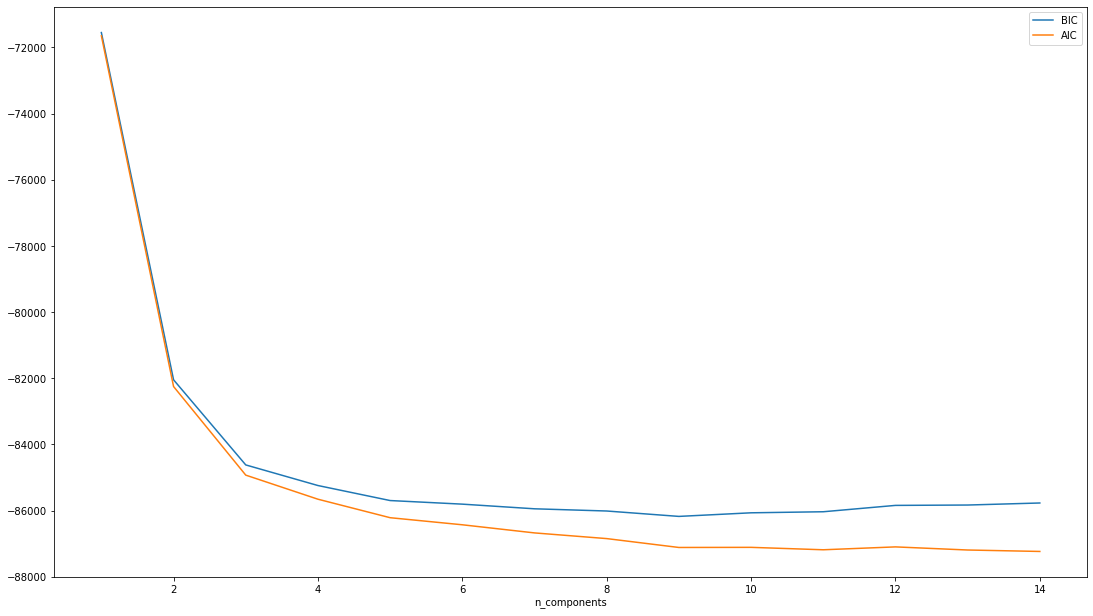

In [76]:
#Check how many regimes we should have optimally
n_components = np.arange(1, 15)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(df) for n in n_components]
plt.plot(n_components, [m.bic(df) for m in models], label='BIC')
plt.plot(n_components, [m.aic(df) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

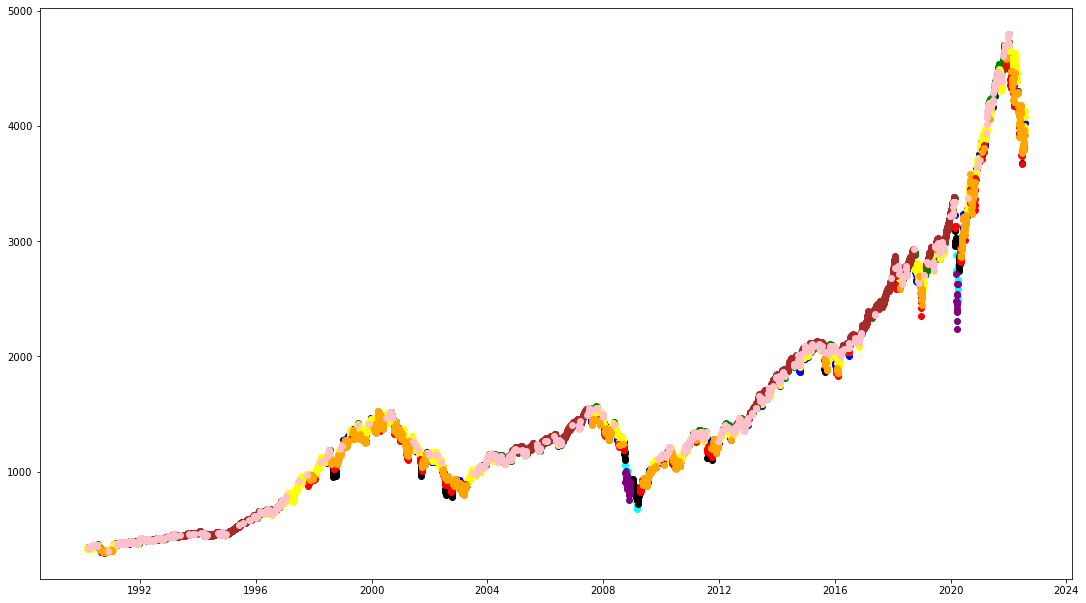

In [77]:
gmm = GaussianMixture(n_components=10)
gmm.fit(df)

#predictions from gmm
labels = gmm.predict(df)
frame = pd.DataFrame(df)
df_replace['regime'] = labels

color=['blue', 'green', 'cyan', 'black', 'yellow', 'red', 'brown', 'orange', 'purple', 'pink']
for k in range(0,10) :
    data = df_replace[df_replace["regime"]==k]
    plt.scatter(data.index, data['Close'], c=color[k])

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()


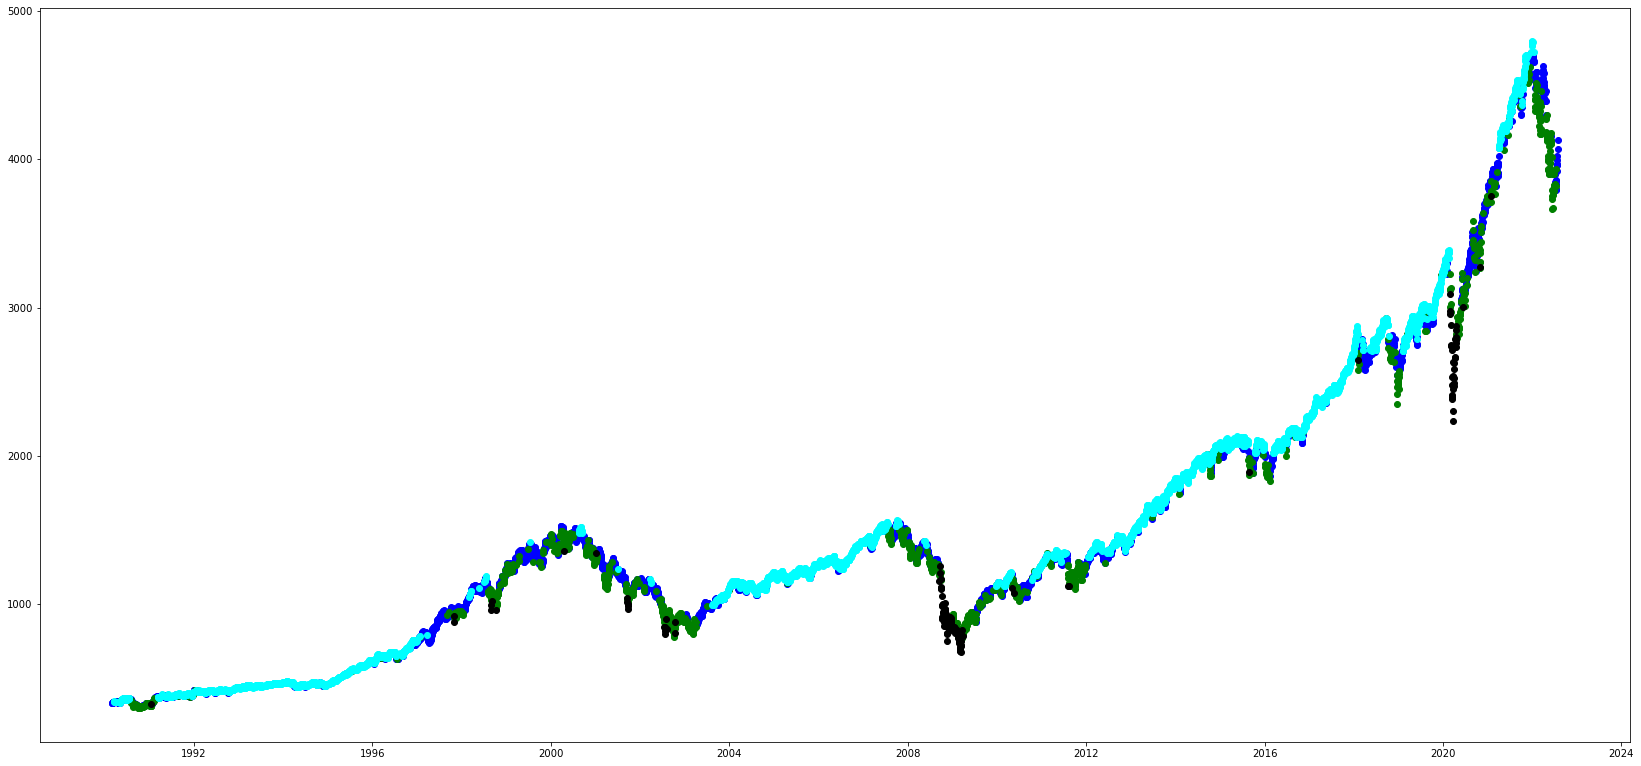

In [78]:
gmm = GaussianMixture(n_components=4)
gmm.fit(df)

#predictions from gmm
labels = gmm.predict(df)
frame = pd.DataFrame(df)
df_replace['regime'] = labels

color=['blue', 'green', 'cyan', 'black']
for k in range(0,4) :
    data = df_replace[df_replace["regime"]==k]
    plt.scatter(data.index, data['Close'], c=color[k])
fig = plt.gcf()
fig.set_size_inches(28.5, 13.5)
plt.show()